## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
parameter_names = c['parameter_names']        
nbidx = 0
print(livetime)
print(sys)
print(parameter_names)

2.154434690031884
Combined
[['amplitude', 'index'], ['amplitude', 'lambda_'], ['lambda_', 'index']]


In [4]:
%%time
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = None)


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 6.13 s, sys: 172 ms, total: 6.31 s
Wall time: 6.32 s


## Datasets

In [5]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
if sys == "Eff_area":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = True
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    e_reco_n = 10
    
if sys == "E_reco":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
    dataset_asimov_N.irf_model.parameters['norm'].frozen = True
    dataset_asimov_N.irf_model.parameters['bias'].frozen = False
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    e_reco_n = 2000
    
    
if sys == "Combined":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['norm'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = False
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    e_reco_n = 2000

    
if sys == "BKG":

    # piece wise model
    # remove old bkg model
    setup.set_up_bkg_sys_V( breake = 10,
                        index1 = 2,
                        index2 = 1.5, 
                        magnitude = magnitude )

    dataset_asimov, dataset_asimov_N = setup.run()

    setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
    setup.set_piecewise_bkg_model(dataset_asimov_N)
    # energy of the following parameters smaller than ethrshold
    dataset_asimov_N.background_model.parameters['norm0'].frozen = True
    dataset_asimov_N.background_model.parameters['norm1'].frozen = True
    dataset_asimov_N.background_model.parameters['norm2'].frozen = True
    dataset_asimov_N.background_model.parameters['norm3'].frozen = True
    setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)

## Minos

In [6]:
numpoints = 20

In [7]:
parameter_names

[['amplitude', 'index'], ['amplitude', 'lambda_'], ['lambda_', 'index']]

In [28]:
def computing_contour(dataset, note, idx = 0):
        
    
    results = []
    for parname1, parname2 in parameter_names[idx:idx+1] :
        print( parname1, parname2)
        
        minuit_opts = {"tol": 10, "strategy": 1}
        fit_cor.backend = "minuit"
        fit_cor.optimize_opts = minuit_opts
        result = fit_cor.stat_contour(dataset,
                             dataset.models.parameters[parname1],
                             dataset.models.parameters[parname2],
                                      numpoints=numpoints 
                            )

        contour_write = dict()
        for k in result.keys():
            print(k)
            if k != "success":
                contour_write[k] = result[k].tolist()

        with open(f"../{c['folder']}/data/3_contour_{note}_{parname1}_{parname2}_{numpoints}_{e_reco_n}.yml", "w") as outfile:
            yaml.dump(contour_write, outfile, default_flow_style=False)

        fig = plt.figure()
        case1 = "spectral"; case2 = "spectral" 
        if parname1 not in ['amplitude', 'index', 'lambda_']:
            case1 = 'spatial'
        if parname2 not in ['amplitude', 'index', 'lambda_']:
            case2 = 'spatial'
            
        plt.plot(result[f"{dataset.models[0].name}.{case1}.{parname1}"],
        result[f"{dataset.models[0].name}.{case2}.{parname2}"])
        results.append(result)
    return results
        
def read_in_contour(note):
    results = []
    for parname1, parname2 in parameter_names :
        try:
            with open(f"../{c['folder']}/data/3_contour_{note}_{parname1}_{parname2}_{numpoints}_{e_reco_n}.yml", "r") as stream:
                contour = yaml.safe_load(stream)
            
        except:
            try:
                with open(f"../{c['folder']}/data/3_contour_{note}_{parname1}_{parname2}_{10}_{e_reco_n}.yml", "r") as stream:
                    contour = yaml.safe_load(stream)
            except:
                 with open(f"../{c['folder']}/data/3_contour_{note}_{parname1}_{parname2}_{5}_{e_reco_n}.yml", "r") as stream:
                    contour = yaml.safe_load(stream)

        results.append(contour)
    return results

def read_in_contour_one(note, idx):
    results = []
    for parname1, parname2 in parameter_names[idx:idx+1] :
        with open(f"../{c['folder']}/data/3_contour_{note}_{parname1}_{parname2}_{numpoints}_{e_reco_n}.yml", "r") as stream:
            contour = yaml.safe_load(stream)
        results.append(contour)
    return results

In [29]:
%%time
dataset_asimov.models.parameters['lon_0'].frozen = True
dataset_asimov.models.parameters['lat_0'].frozen = True

fit_cor = Fit()
result = fit_cor.run(dataset_asimov)

CPU times: user 4.3 s, sys: 1.49 s, total: 5.8 s
Wall time: 5.81 s


In [30]:
result.minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.928e+04                  │              Nfcn = 73               │
│ EDM = 5.75e-10 (Goal: 0.0002)    │            time = 5.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index     │   2.30    │   0.09    │            │            │         │         │       │
│ 1 │ par_001_amplitude │   3.85    │   0.25    │            │            │         │         │       │
│ 2 │ par_002_lambda_   │    1.0    │    0.4    │            │            │         │         │       │
│ 3 │ par_003_norm      │   1.000   │   0.011   │            │            │         │         │       │
│ 4 │ par_004_tilt      │   0.000   │   0.012   │            │            │         │         │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│                   │     par_000_index par_001_amplitude   par_002_lambda_      par_003_norm      par_004_tilt │
├───────────────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│     par_000_index │           0.00778            -0.015            -0.028                -0          -0.03e-3 │
│ par_001_amplitude │            -0.015            0.0626              0.08          -0.08e-3                -0 │
│   par_002_lambda_ │            -0.028              0.08             0.145           0.01e-3                -0 │
│      par_003_norm │                -0          -0.08e-3           0.01e-3          0.000115           0.01e-3 │
│      par_004_tilt │          -0.03e-3                -0                -0           0.01e-3          0.000134 │
└───────────────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

(<WCSAxes: >,
 <Axes: xlabel='Energy [$\\mathrm{TeV}$]', ylabel='Residuals (data - model)'>)

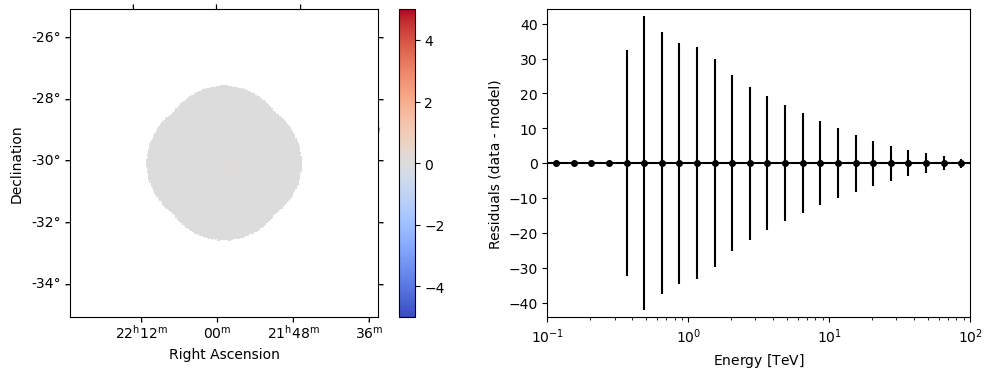

In [31]:
dataset_asimov.plot_residuals()

In [41]:
%%time
numpoints = 30
computing = 0
if computing:
    results = computing_contour(dataset_asimov, "2.15h", 0)
    results = computing_contour(dataset_asimov, "2.15h", 1)
    results = computing_contour(dataset_asimov, "2.15h", 2)
else:
    results = read_in_contour("2.15h")
    #results = read_in_contour_one("2.15h",0 )
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models = Models.read(path)
    


CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 30.7 ms


In [42]:
%%time
fitting_N = 0 
if fitting_N:
    dataset_asimov_N.e_reco_n = e_reco_n

    dataset_asimov_N.models.parameters['lon_0'].frozen = True
    dataset_asimov_N.models.parameters['lat_0'].frozen = True

    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run(dataset_asimov_N)
    print(result_cor)
    print(dataset_asimov_N.models)
    result_cor.minuit

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


In [43]:
%%time
computing = 0
numpoints = 20

if computing:
    #results_N = computing_contour(dataset_asimov_N, "N_2.15h",0)
    results_N = computing_contour(dataset_asimov_N, "N_2.15h",1)
    #results_N = computing_contour(dataset_asimov_N, "N_2.15h",2)
else:
    results_N = read_in_contour("N_2.15h")
    #results_N = read_in_contour_one("N_2.15h", 0)
    
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}.yml'
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        


CPU times: user 99.1 ms, sys: 25.1 ms, total: 124 ms
Wall time: 126 ms


In [44]:
from scipy.interpolate import interp1d

def remove_duplicates(a, b):
    filtered_a = []
    filtered_b = []
    unique_values = {}
    for x, y in zip(a, b):
        if x not in unique_values:
            unique_values[x] = y
            filtered_a.append(x)
            filtered_b.append(y)
    return filtered_a, filtered_b

def interpolate(one, two):
    one, two =  rearange(one,two)
    one, two =  remove_duplicates(one,two)
    
    points = np.column_stack((one, two))  # a (nbre_points x nbre_dim) array
    

    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    # Interpolation for different methods: #quadratic
    interpolations_methods = ['quadratic']
    alpha = np.linspace(0, 1, 75)

    interpolated_points = {}
    for method in interpolations_methods:
        interpolator =  interp1d(distance, points, kind=method, axis=0)
        interpolated_points[method] = interpolator(alpha)
        
    for method_name, curve in interpolated_points.items():
        c_int = {'x':curve.T[0], 'y': curve.T[1]}
        
    a,b = list(c_int['x']), list(c_int['y'])
    a.append(a[0])
    b.append(b[0])
    return a,b


def rearange(a,b):
    centroid = (sum(a) / len(a), sum(b) / len(b))

    def angle_from_centroid(x, y):
        return np.arctan2(y - centroid[1], x - centroid[0])

    contour_points = [(x, y) for x, y in zip(a, b)]
    contour_points.sort(key=lambda point: angle_from_centroid(point[0], point[1]))

    if np.cross(np.array(contour_points[1]) - np.array(contour_points[0]), 
                np.array(contour_points[-1]) - np.array(contour_points[0])) < 0:
        contour_points.reverse()
        
    #contour_points.append(contour_points[0])
    a, b = zip(*contour_points)
    return a,b

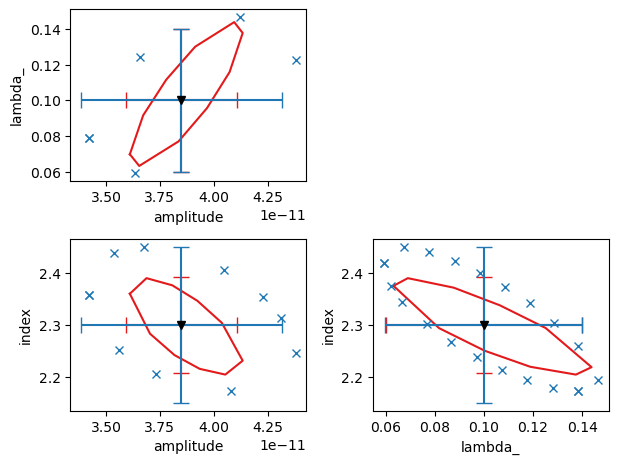

In [45]:
fig,axs = plt.subplots(2,2)
#axs = axs.flatten()
axs = [axs[1][0], axs[0][0], axs[1][1], axs[0][1]]
for i,p in enumerate(parameter_names):
    a = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
    b = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
     
    axs[i].plot(a, b, color = awo[0])
    axs[i].errorbar(x = dataset_asimov.models[0].parameters[p[0]].value,
                    y = dataset_asimov.models[0].parameters[p[1]].value,
                    xerr = dataset_asimov.models[0].parameters[p[0]].error,
                    yerr = dataset_asimov.models[0].parameters[p[1]].error,
                    color = awo[0],
                    capsize = 6,
                    label = "fit w/o systematic"
                    
                   )
    
    a = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
    b = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
    axs[i].plot(a, b, color = aw[0], marker = 'x' , linestyle = '' )
    axs[i].errorbar(x = dataset_asimov_N.models[0].parameters[p[0]].value,
                    y = dataset_asimov_N.models[0].parameters[p[1]].value,
                    xerr = dataset_asimov_N.models[0].parameters[p[0]].error,
                    yerr = dataset_asimov_N.models[0].parameters[p[1]].error,
                    color = aw[0],
                    capsize = 6,
                    label = "fit with systematic"
                   )
    axs[i].errorbar(x = dataset_input.models[0].parameters[p[0]].value,
                    y = dataset_input.models[0].parameters[p[1]].value,
                    color = 'black',
                    marker = 'v',
                    capsize = 6,
                    label = "input"
                   )
    axs[i].set_xlabel(p[0])
    axs[i].set_ylabel(p[1])  
plt.tight_layout()
axs[-1].axis('off')
plt.savefig(f"../{c['folder']}/plots/3_contours.pdf")

In [46]:
parameter_names

[['amplitude', 'index'], ['amplitude', 'lambda_'], ['lambda_', 'index']]

In [47]:
from scipy.interpolate import interp1d
def interpolate(one, two):
    
    points = np.column_stack((one, two))  # a (nbre_points x nbre_dim) array
    

    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    # Interpolation for different methods: #quadratic
    interpolations_methods = ['quadratic']
    alpha = np.linspace(0, 1, 75)

    interpolated_points = {}
    for method in interpolations_methods:
        interpolator =  interp1d(distance, points, kind=method, axis=0)
        interpolated_points[method] = interpolator(alpha)
        
    for method_name, curve in interpolated_points.items():
        c_int = {'x':curve.T[0], 'y': curve.T[1]}
    return np.array(c_int['x']), np.array(c_int['y'])

from gammapy.visualization import plot_contour_line
fig, ax = plt.subplots(1,1)


In [145]:
def transform_amplitude(a,b):
    if a[0]< 1e-4:
        a= np.array(a)* 1e11
    if b[0]< 1e-4:
        b= np.array(b)* 1e11
    return a,b
def transform_amplitude2(x,y,xerr, yerr):
    pars = [x,y,xerr, yerr]
    for p  in (pars):
         p = mupli(p)
    return pars

def mupli(value):
    if value< 1e-4:
        value= np.array(value)* 1e11
    return value

amplitude
[3.420597909668298e-11, 3.561936756347469e-11, 3.7326779008882825e-11, 4.078035392285569e-11, 4.3808017780936286e-11, 4.3135072528749407e-11, 4.227134737095206e-11, 4.0464299955612534e-11, 3.6781540791488633e-11, 3.5365930429732696e-11, 3.420597909668298e-11]
[2.3569551488184697, 2.250874269621902, 2.205297037667687, 2.1717961909103147, 2.2460045987950625, 2.3137179744483047, 2.3543805233679853, 2.4063872239304485, 2.449975350637266, 2.4388589377866006, 2.3569551488184697]
3.85e-11 2.3 4.6529205990189685e-12 0.15013520562561583
3.85e-11 2.3 4.6529205990189685e-12 0.15013520562561583
amplitude
[3.420597909668298e-11, 3.633646246077373e-11, 4.3808017780936286e-11, 4.1226815159689136e-11, 3.6599397071374574e-11, 3.420597909668298e-11]
[0.07889361101809705, 0.05921803234966902, 0.1223973546369102, 0.14653187834066805, 0.12430717870567383, 0.07889361101809705]
3.85e-11 0.1 4.6529205990189685e-12 0.040058402651962796
3.85e-11 0.1 4.6529205990189685e-12 0.040058402651962796
lambda_


IndexError: invalid index to scalar variable.

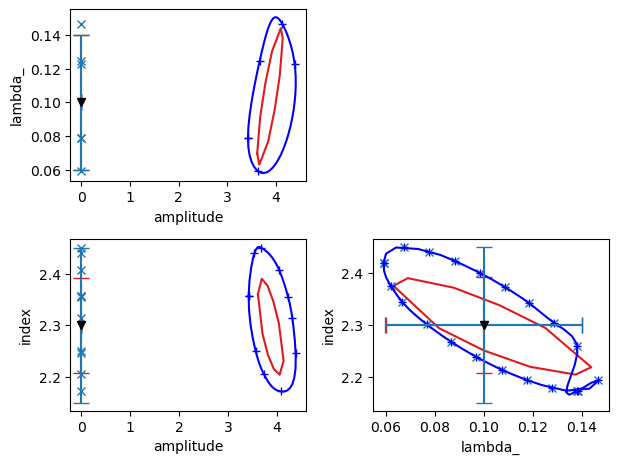

In [148]:
fig,axs = plt.subplots(2,2)
#axs = axs.flatten()
axs = [axs[1][0], axs[0][0], axs[1][1], axs[0][1]]
for i,p in enumerate(parameter_names):
    if p[0] == "amplitude":
        factor = 1e11
    print(p[0])
    a = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
    b = results[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
    a, b = transform_amplitude(a,b)
    axs[i].plot(a, b, color = awo[0])
    x = dataset_asimov.models[0].parameters[p[0]].value
    y = dataset_asimov.models[0].parameters[p[1]].value
    xerr = dataset_asimov.models[0].parameters[p[0]].error
    yerr = dataset_asimov.models[0].parameters[p[1]].error
    x,y,xerr, yerr = transform_amplitude2(x,y,xerr, yerr)
    
    axs[i].errorbar(x = x, y = y , xerr = xerr, yerr = yerr,
                    color = awo[0],
                    capsize = 6,
                    label = "fit w/o systematic"
                    
                   )
    
    a = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[0]}']    
    b = results_N[i][f'{dataset_asimov.models[0].name}.spectral.{p[1]}']
    print(a) 
    print(b)
    axs[i].plot(a, b, color = aw[0], marker = 'x' , linestyle = '' )
    
    #a, b = interpolate(a,b)
    a, b = transform_amplitude(a,b)
    
    #axs[i].plot(a, b, color = aw[0], )
    plot_contour_line(axs[i], a, b, )
    #axs[i].plot(a, b, color = aw[0], marker = 'x' , linestyle = '' )
    x = dataset_asimov_N.models[0].parameters[p[0]].value
    y = dataset_asimov_N.models[0].parameters[p[1]].value
    xerr = dataset_asimov_N.models[0].parameters[p[0]].error
    yerr = dataset_asimov_N.models[0].parameters[p[1]].error
    print(x,y,xerr, yerr)
    
    x,y,xerr, yerr = transform_amplitude2(x,y,xerr, yerr)
    print(x,y,xerr, yerr)
    axs[i].errorbar(x = x, y = y , xerr = xerr, yerr = yerr,
                    color = aw[0],
                    capsize = 6,
                    label = "fit with systematic"
                   )
    axs[i].errorbar(x = dataset_input.models[0].parameters[p[0]].value,
                    y = dataset_input.models[0].parameters[p[1]].value,
                    color = 'black',
                    marker = 'v',
                    capsize = 6,
                    label = "input"
                   )
    axs[i].set_xlabel(p[0])
    axs[i].set_ylabel(p[1])  
plt.tight_layout()
axs[-1].axis('off')
plt.savefig(f"../{c['folder']}/plots/3_contours.pdf")

In [63]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Given data points
x_values = np.array([3.420597909668298e-11, 3.561936756347469e-11, 3.7326779008882825e-11, 4.078035392285569e-11, 4.3808017780936286e-11, 4.3135072528749407e-11, 4.227134737095206e-11, 4.0464299955612534e-11, 3.6781540791488633e-11, 3.5365930429732696e-11, 3.420597909668298e-11])
y_values = np.array([2.3569551488184697, 2.250874269621902, 2.205297037667687, 2.1717961909103147, 2.2460045987950625, 2.3137179744483047, 2.3543805233679853, 2.4063872239304485, 2.449975350637266, 2.4388589377866006, 2.3569551488184697])

# Convert data points to coordinates suitable for OpenCV
points = np.column_stack((x_values, y_values)).astype(np.float32)

# Fit an ellipse to the points
ellipse = cv2.fitEllipse(points)

# Create an image to draw the ellipse on
img = np.zeros((400, 400, 3), dtype=np.uint8)

# Draw the ellipse
cv2.ellipse(img, ellipse, (0,255,0), 2)

# Draw the data points
for x, y in points:
    cv2.circle(img, (int(x*1e11), int(y)), 1, (255,0,0), -1)

# Show the result
plt.imshow(img)
plt.show()


ModuleNotFoundError: No module named 'cv2'

In [77]:
x_values

array([3.42059791, 3.56193676, 3.7326779 , 4.07803539, 4.38080178,
       4.31350725, 4.22713474, 4.04643   , 3.67815408, 3.53659304,
       3.42059791])

/tmp/ipykernel_188440/3658472332.py:20: RuntimeWarning: invalid value encountered in sqrt
  width = np.sqrt(numerator/denominator1)


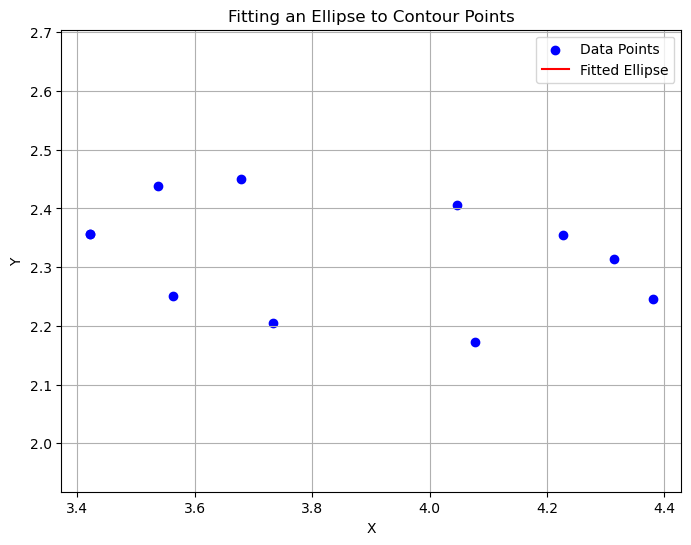

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Given data points
x_values = np.array([3.420597909668298e-11, 3.561936756347469e-11, 3.7326779008882825e-11, 4.078035392285569e-11, 4.3808017780936286e-11, 4.3135072528749407e-11, 4.227134737095206e-11, 4.0464299955612534e-11, 3.6781540791488633e-11, 3.5365930429732696e-11, 3.420597909668298e-11])*1e11
y_values = np.array([2.3569551488184697, 2.250874269621902, 2.205297037667687, 2.1717961909103147, 2.2460045987950625, 2.3137179744483047, 2.3543805233679853, 2.4063872239304485, 2.449975350637266, 2.4388589377866006, 2.3569551488184697])

# Formulate and solve the least squares problem Ax = b
A = np.column_stack((x_values**2, x_values*y_values, y_values**2, x_values, y_values, np.ones_like(x_values)))
b = np.ones_like(x_values)
solution = np.linalg.lstsq(A, b, rcond=None)[0]
# Get the parameters of the ellipse
a, b, c, d, f, g = solution[0], solution[1]/2, solution[2], solution[3]/2, solution[4]/2, solution[5]
center_x = (c*d - b*f) / (b**2 - a*c)
center_y = (a*f - b*d) / (b**2 - a*c)
# Get the semi-axes lengths
numerator = 2*(a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
denominator1 = (b**2 - a*c)*((c-a)*np.sqrt(1+4*b**2/((a-c)**2)) - (c+a))
denominator2 = (b**2 - a*c)*((a-c)*np.sqrt(1+4*b**2/((a-c)**2)) - (c+a))
width = np.sqrt(numerator/denominator1)
height = np.sqrt(numerator/denominator2)
# Get the orientation of the ellipse
phi = 0.5 * np.arctan((2*b) / (a - c))

# Generate points on the fitted ellipse for plotting
theta = np.linspace(0, 2*np.pi, 1000)
x_ellipse = center_x + width * np.cos(theta) * np.cos(phi) - height * np.sin(theta) * np.sin(phi)
y_ellipse = center_y + width * np.cos(theta) * np.sin(phi) + height * np.sin(theta) * np.cos(phi)
# Plot the data points and the fitted ellipse
plt.figure(figsize=(8, 6))
plt.scatter(x_values, y_values, label='Data Points', color='blue')
plt.plot(x_ellipse, y_ellipse, label='Fitted Ellipse', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting an Ellipse to Contour Points')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [78]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [82]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

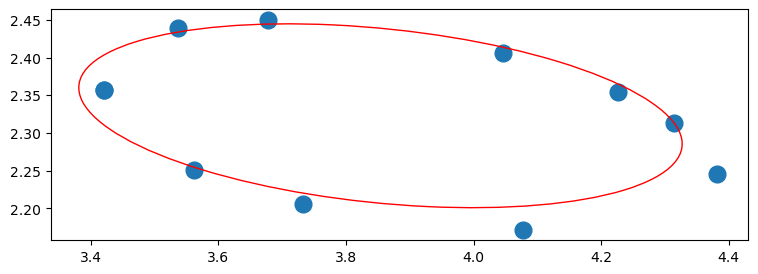

In [92]:
np.random.seed(0)


mu = 2, 4
scale = 3, 5

fig, ax = plt.subplots(1,1, figsize=(9, 3))
ax.scatter(x_values, y_values, s=145)


confidence_ellipse(x_values, y_values, ax, edgecolor='red',  n_std=1.3)

#ax.scatter(mu[0], mu[1], c='red', s=3)

plt.show()

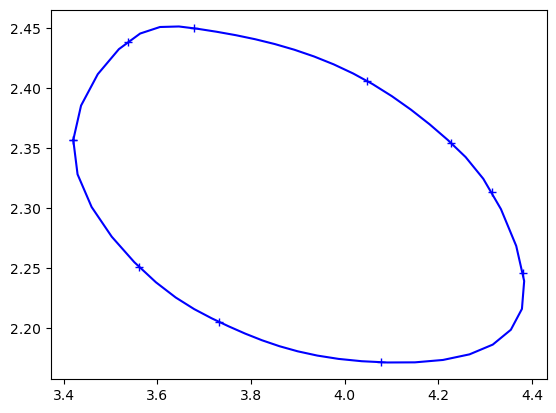